While looking for anomaly detection techniques one will come across wealthy sets of techniques online, which range from statistical methods to machine learning to neural network (of course. NN can do anything lol). One particular detection method caught my eyes recently and it reads

<p style="border:1px solid black; padding:1em;font-style:italic;color:gray">"The underlying algorithm – referred to as <b>Seasonal Hybrid ESD (S-H-ESD)</b> builds upon the <b>Generalized ESD test</b> for detecting anomalies. Note that S-H-ESD can be used to detect both global as well as local anomalies. This is achieved by employing <b>time series decomposition</b> and using <b>robust statistical</b> metrics, viz., <b>median</b> together with ESD. In addition, for long time series (say, 6 months of minutely data), the algorithm employs <b>piecewise</b> approximation - this is rooted to the fact that trend extraction in the presence of anomalies in non-trivial - for anomaly detection."</p>


That's right! That's Twitter Anomaly Detection from Twitter (it's only in R now. Twitter data scientists uses R mainly?) and it was introduced mainly for time series data. To refresh, detection methods range from simple ones like
- boxplot, winsorization, tukey's method, IQR, zscore>3....
- to MAD, Double MAD (not really good for large samples), moving average, exponential moving average...
- to KNN, random forest, unsupervised learning methods like isolation forest (my favorite), kmeans, GMM, DBSCAN, LOF...
- to forecasting models like SARIMA, STL, Holt-Winsters, Prophet with Fourier Transform...

I'm out of breath. **But I've have never heard of ESD. What makes me excited about learning more is that**
1. it's built upon some easy-to-understand statistical calculations and transparent process.
2. Student's t-distribution is used. The familiar hypothesis testing concept is used.
3. I feel it's simpler to understand than Prophet's Fourier Transform and some Bayesian.

# 1. Grubb's Test

To understand Twitter's Anomaly Detection underlying algorithm, we need to start from the basics. ESD stands for _Extreme Studentized Deviate_. Generalized ESD is an extension of Grubb's test, which is a hypothesis testing, so it has a **test statistics!** Grubbs’ test is used to find a single outlier in a normally distributed data set. It's deceptively simple to run. It checks for outliers by looking for the maximum of the absolute deviation between the values and the mean, and then decides whether this deviation is an outlier based on it's own home-made G statistic. Basically, the steps are:

- Find the G test statistic >> Find the G Critical Value >> Reject the point as an outlier if the test statistic is greater than the critical value.

Grubb's test

- H(null): There's no outlier in the data.
- H(alt): There's **(exactly) one** outlier in the data.

The G statistic is simply the maximum deviation (z-score) from the mean, while the G Critical Value can be found via table or formula. It depends on t-distribution so the value depends the alpha level and number of samples. Note that, the z-score can be modified with median and MAD.

<br>
<table style="margin:0px">
  <tr>
      <th colspan=3 style="text-align:left; font-size: 16px">1. G statistics</th>
  </tr>
  <tr>
    <td style="text-align:center">For two-tailed test<br>(To find anomaly at both ends)</td>
    <td style="text-align:center">For left-tailed test<br>(To find anomaly at the low end)</td> 
    <td style="text-align:center">For right-tailed test<br>(To find anomaly at the high end)</td>
  </tr>
  <tr style="background: none">
    <td><img src="images\grubbs-test-statistic.png"><br>ȳ is the sample mean<br>s = sample standard deviation.</td>
    <td><img src="images\grubbs-2.png"><br>Y<sub>min</sub> is the minimum value.</td> 
    <td><img src="images\grubbs-3.png"><br>Y<sub>max</sub> is the maximum value.</td>
  </tr>
</table>
<br>

<table style="margin:0px">
  <tr>
    <th style="text-align:left; font-size: 16px">2. G critical value</th>
  </tr>
  <tr>
      <td><img src="images\grubbs-4.png"><p>Where:<br>
          t<sub>α/(2N),N−2</sub> is the upper critical value of a t-distribution with N-2 degrees of freedom.<br>
          For one-tailed test, replace α/(2N) with α/N.</p></td>
  </tr>
</table>
<br>

<table style="margin:0px">
  <tr>
    <th style="text-align:left; font-size: 16px">3. Compare your G test statistic to the G critical value:</th>
  </tr>
  <tr>
      <td style="text-align:left;">G < G<sub>critical</sub>: keep the point in the data set; it is not an outlier.<br>
G > G<sub>critical</sub>: reject the point as an outlier.</td>
  </tr>
</table>

# 2. ESD _for multiple outliers_

_The Generalized Extreme Studentized Deviate (ESD) Test is a generalization of Grubbs’ Test and handles more than one outlier. All you need to do is provide an upper bound on the number of potential outliers._

If we have multiple outliers, we can try two methods:
1. Perform a Grubb's test and remove the outlier before performing a new test again. This can be achieved using a while loop. The iteration stops when a Grubb's test failed to reject. 
2. G-ESD, where you specify the number of potential outliers, k in the data. k becomes the number of iteration of Grubb's test, ie. Grubb's will be performed k times. In each iteration, 1 point will be remove regardless of whether it's an outlier. Any point before the last test where G > G<sub>critical</sub> (ie. h(null) rejected, it's signicant) will be considered an outlier.

To illustrate, consider a G-ESD test with k=6. Method (1) would have stopped at first iteration and yielded no outlier.

<table>
    <tr>
        <th>Iteration</th>
        <th>y with largest deviation</th>
        <th>G</th>
        <th>G-critical</th>
        <th>sig</th>
        <th>Note</th>
        <th>End result</th>
    </tr>
    <tr>
        <td>1</td>
        <td>440</td>
        <td>2.497556</td>
        <td>2.757735</td>
        <td>no</td>
        <td>Removed for the next test</td>
        <td>Outlier</td>
    </tr>
    <tr>
        <td>2</td>
        <td>410</td>
        <td>2.729992</td>
        <td>2.73378</td>
        <td>no</td>
        <td>Removed for the next test</td>
        <td>Outlier</td>
    </tr>
    <tr>
        <td>3</td>
        <td>350</td>
        <td>2.714963</td>
        <td>2.708246</td>
        <td>yes</td>
        <td>Removed for the next test</td>
        <td>Outlier</td>
    </tr>
    <tr>
        <td>4</td>
        <td>3</td>
        <td>2.721414</td>
        <td>2.680931</td>
        <td>yes</td>
        <td>Removed for the next test</td>
        <td>Outlier</td>
    </tr>
    <tr>
        <td>5</td>
        <td>40</td>
        <td>2.83852</td>
        <td>2.651599</td>
        <td>yes</td>
        <td>Removed for the next test</td>
        <td>Outlier</td>
    </tr>
    <tr>
        <td>6</td>
        <td>220</td>
        <td>1.707766</td>
        <td>2.619964</td>
        <td>no</td>
        <td>End</td>
        <td>Test end. Not an outlier</td>
    </tr>
</table>

**Note:** G-ESD is essentially a two-tailed test and using this test on non-normal distributions will give false results.
Run a test for normality (like the Shapiro-Wilk test) before running Grubbs’ or G-ESD test. If you find your data set isn’t normally distributed, try removing the potential outlier from the data set and running the normality test again. If your data still isn’t normal, don’t run this test.

In [1]:
import numpy as np
from scipy.stats import t, zscore

def grubb(X, alpha=0.05):
    Z = zscore(X, ddof=1)  # Z-score
    N = len(X)  # number of samples

    G = np.abs(Z).max() # calculate G statistics
    G_loc = np.abs(Z).argmax()

    t_crit =  t.isf(alpha / (2*N), N-2) # two-tailed test. ".isf()" gives the variate from the probability
    G_crit = (N - 1) / np.sqrt(N) * np.sqrt(t_crit**2 / (N - 2 + t_crit**2)) # calculate G-critical value

    if G > G_crit:
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f}'.format(X[G_loc], G, G_crit))
    else:
        print('{} is not an outlier. G < G-critical: {:.4f} < {:.4f}'.format(X[G_loc], G, G_crit))
    
    return G_loc, G, G_crit

In [2]:
# Grubb's test stops at iteration 1.

X = [145,125,190,135,220,130,210,3,165,165,150,350,170,180,195,440,215,135,410,40,140,175]
G = 1
G_crit = 0

while G > G_crit:
    G_loc, G, G_crit = grubb(X)
    X = np.delete(X, G_loc)

440 is not an outlier. G < G-critical: 2.4976 < 2.7577


In [3]:
# Generalized-ESD test identified 5 outliers with 6 or more iterations

X = [145,125,190,135,220,130,210,3,165,165,150,350,170,180,195,440,215,135,410,40,140,175]
k = 6

for i in range(k):
    G_loc, G, G_crit = grubb(X)
    X = np.delete(X, G_loc)

440 is not an outlier. G < G-critical: 2.4976 < 2.7577
410 is not an outlier. G < G-critical: 2.7300 < 2.7338
350 is an outlier. G > G-critical: 2.7150 > 2.7082
3 is an outlier. G > G-critical: 2.7214 > 2.6809
40 is an outlier. G > G-critical: 2.8385 > 2.6516
220 is not an outlier. G < G-critical: 1.7078 < 2.6200


In [4]:
X = [145,125,190,135,220,130,210,3,165,165,150,350,170,180,195,440,215,135,410,40,140,175]
k = 15
outliers = []
i_last_outlier = 0

for i in range(k):
    G_loc, G, G_crit = grubb(X)
    outliers.append(X[G_loc])
    X = np.delete(X, G_loc)
    
    if G > G_crit:
        i_last_outlier = i

print('\n\nGeneralized ESD Test outliers:',outliers[:i_last_outlier+1])

440 is not an outlier. G < G-critical: 2.4976 < 2.7577
410 is not an outlier. G < G-critical: 2.7300 < 2.7338
350 is an outlier. G > G-critical: 2.7150 > 2.7082
3 is an outlier. G > G-critical: 2.7214 > 2.6809
40 is an outlier. G > G-critical: 2.8385 > 2.6516
220 is not an outlier. G < G-critical: 1.7078 < 2.6200
215 is not an outlier. G < G-critical: 1.7816 < 2.5857
210 is not an outlier. G < G-critical: 1.8945 < 2.5483
195 is not an outlier. G < G-critical: 1.6449 < 2.5073
190 is not an outlier. G < G-critical: 1.6953 < 2.4620
180 is not an outlier. G < G-critical: 1.5160 < 2.4116
175 is not an outlier. G < G-critical: 1.5085 < 2.3547
170 is not an outlier. G < G-critical: 1.5046 < 2.2900
165 is not an outlier. G < G-critical: 1.5087 < 2.2150
165 is not an outlier. G < G-critical: 1.9254 < 2.1266


Generalized ESD Test outliers: [440, 410, 350, 3, 40]


# 3. Arriving at Twitter's Anomaly Detection Algorithm: Seasonal Hybrid-ESD

<p style="border:1px solid black; padding:1em;font-style:italic;color:gray">"We developed two novel statistical techniques for automatically detecting anomalies in cloud infrastructure data. Specifically, the techniques employ statistical learning to detect anomalies in both application, and system metrics. Seasonal decomposition is employed to filter the trend and seasonal components of the time series, followed by the use of robust statistical metrics – median and median absolute deviation (MAD) – to accurately detect anomalies, even in the presence of seasonal spikes."</p>

The problem with the G-ESD test is that it assumes a normal data distribution, while real world data can have a multimodal distribution. To circumvent this, Twitter first employs seasonal decomposition to remove the seasonal and trend component from the time series, leaving the residual component, similar to STL. The key is that the residual has a unimodal distribution that is amenable for the application of G-ESD test. **While Twitter's method of removing the seasonal component is identical to STL, here Twitter's method of removing the trend differs from STL in that Twitter performs it by removing the median of the data rather than fitting a LOESS smoother.** The median works well when a long-term trend is less dominant than the short-term seasonal component. This is because the smoother tends to overfit the anomalies.

However, extreme, spurious anomalies or high percentage of anomalies may present in the residual component. To fix it, Twitter proposes to use the median and Median Absolute Deviate (MAD) instead of the mean and standard deviation to compute a modified zscore in G-ESD test, as they are more robust to outliers.

## 3.1 Data type I - Twitter's raw data

This example uses Twitter's raw data obtained online. Twitter's Anomaly Detection package is in R. There exists several github repo that have ported to Python. I have used a Python implementation from this [github repo](https://github.com/Marcnuth/AnomalyDetection). It takes ~9s to process a time series containing 14398 data point on my Core-i7 laptop which in my opinion is quite slow at max_anoms=0.1 (maximum 10% anomalies. Remember we have to specify the max number of potential anomalies?). I think Twitter's R implementation should have been optimized for speed.

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
from anomaly_detection import anomaly_detect_ts as tad

ts = pd.read_csv('data\raw_data.csv').set_index('timestamp')['count']
ts.index = pd.to_datetime(ts.index)
ts.head()

timestamp
1980-09-25 14:01:00    182.478
1980-09-25 14:02:00    176.231
1980-09-25 14:03:00    183.917
1980-09-25 14:04:00    177.798
1980-09-25 14:05:00    165.469
Name: count, dtype: float64

Wall time: 4.41 s


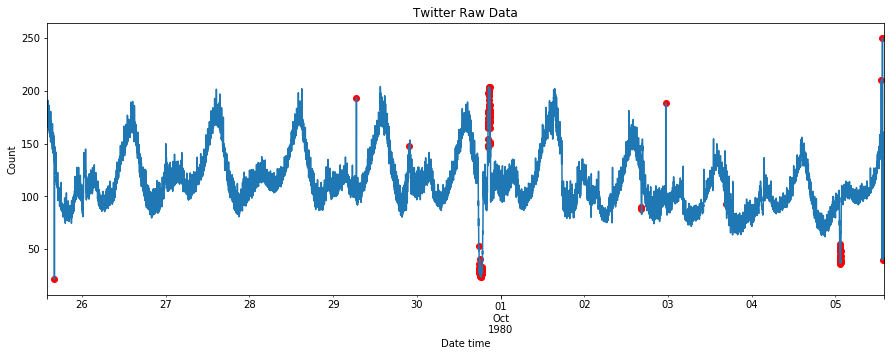

In [280]:
%time anom_dict = tad(ts, max_anoms=0.05, direction='both', alpha=0.05, piecewise_median_period_weeks=2)
anoms = anom_dict['anoms']

fig, ax = plt.subplots(1, figsize=(15,5))
ts.plot(ax=ax)
ax.scatter(anoms.index.values, anoms, color='red')
ax.set_xlabel('Date time')
ax.set_ylabel('Count')
ax.set_title('Twitter Raw Data');

You can see below that even with specifying higher maximum number of potential anomalies, the result is still the same, as the ESD has not found any significant G test statistics anymore. Using lower max_anoms can potentially save some time, with the risk of missing potential anomalies.

Wall time: 9.23 s
Wall time: 16.1 s
Wall time: 23.6 s
Wall time: 31.7 s


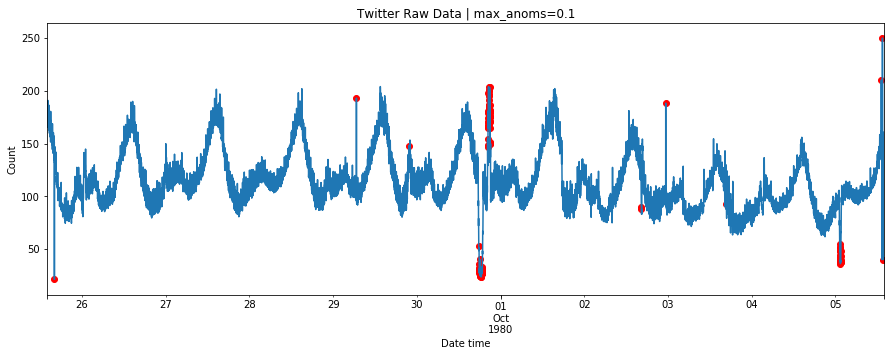

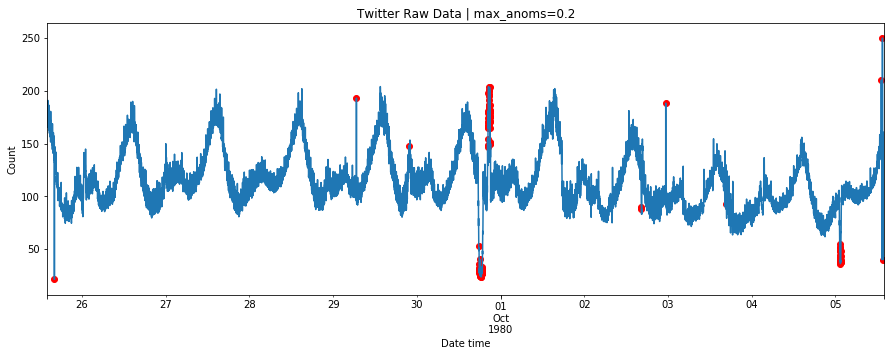

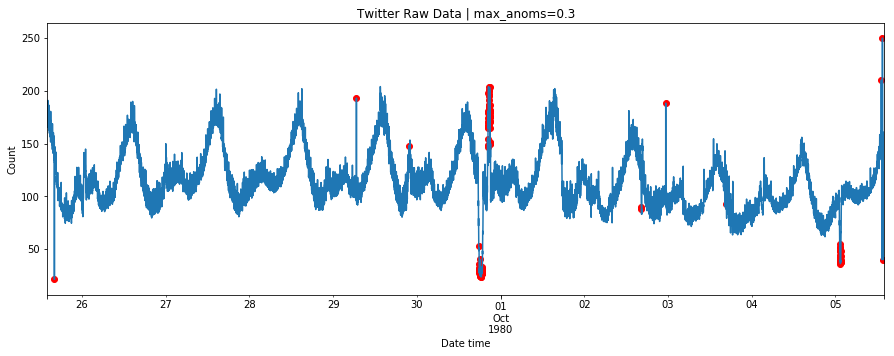

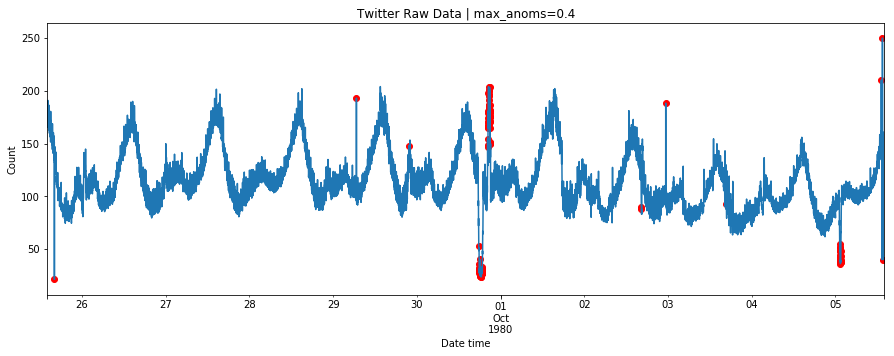

In [277]:
for p in [0.1,0.2,0.3,0.4]:
    %time anom_dict = tad(ts, max_anoms=p, direction='both', alpha=0.05, piecewise_median_period_weeks=2)
    anoms = anom_dict['anoms']

    fig, ax = plt.subplots(1, figsize=(15,5))
    ts.plot(ax=ax)
    ax.scatter(anoms.index.values, anoms, color='red')
    ax.set_xlabel('Date time')
    ax.set_ylabel('Count')
    ax.set_title('Twitter Raw Data | max_anoms='+str(p));

## 3.2 Data type II - Hotel room booking sales data

In the past I've tried Twitter's Anomaly Detection with flight sales when I was working in MAS but with bad results. I am attempting to demonstrate again with this dataset which looks similar. For certain unpopular routes, the sales or booking count is either too low or is 0 on some days. As you see below, this kind of data does not exhibit a nice-looking pattern like the one above, even when I resampled to daily later.

In [233]:
ts2 = pd.read_csv('data\ts_data.csv').set_index('date_time')['price_usd']
ts2.index = pd.to_datetime(ts2.index)
ts2 = ts2[ts2 < 5584]
ts2 = ts2.resample('1T').sum()
print(ts2.shape)
ts2.head()

(348243,)


date_time
2012-11-01 02:48:00    84.0
2012-11-01 02:49:00     0.0
2012-11-01 02:50:00     0.0
2012-11-01 02:51:00     0.0
2012-11-01 02:52:00     0.0
Freq: T, Name: price_usd, dtype: float64

In [227]:
ts2.describe()

count    348243.000000
mean          0.972789
std          11.611420
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         536.000000
Name: price_usd, dtype: float64

In [228]:
%time anom_dict = tad(ts2, max_anoms=0.1, direction='both', alpha=0.05, piecewise_median_period_weeks=2)

Wall time: 8min 13s


In [244]:
anoms = anom_dict['anoms']

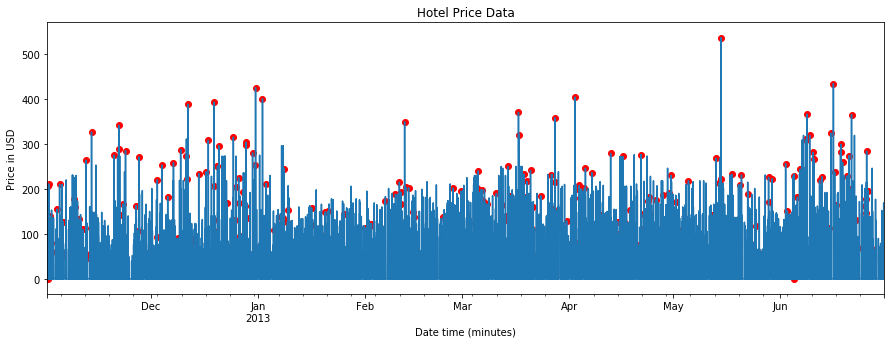

In [245]:
fig, ax = plt.subplots(1, figsize=(15,5))
ts2.plot(ax=ax)
ax.scatter(anoms.index.values, anoms, color='red')
ax.set_xlabel('Date time (minutes)')
ax.set_ylabel('Price in USD')
ax.set_title('Hotel Price Data');

Let's zoom in! Does it look nice to you?

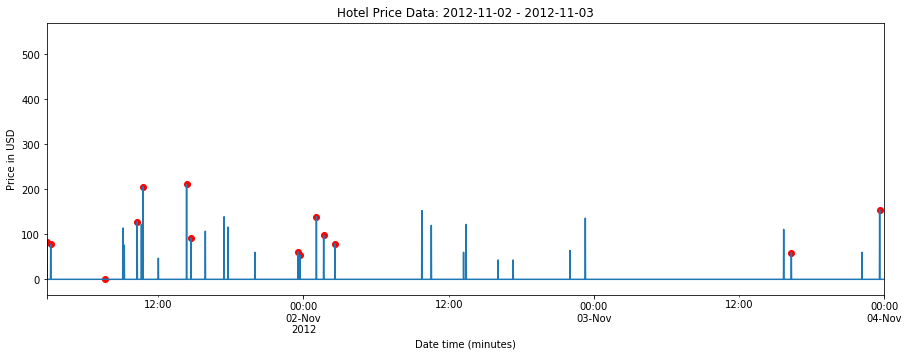

In [263]:
fig, ax = plt.subplots(1, figsize=(15,5))
ts2.plot(ax=ax, xlim=(None,'2012-11-04'))
ax.scatter(anoms.index.values, anoms, color='red')
ax.set_xlabel('Date time (minutes)')
ax.set_ylabel('Price in USD')
ax.set_title('Hotel Price Data: 2012-11-02 - 2012-11-03');

Resampled to daily and run again.

Wall time: 320 ms


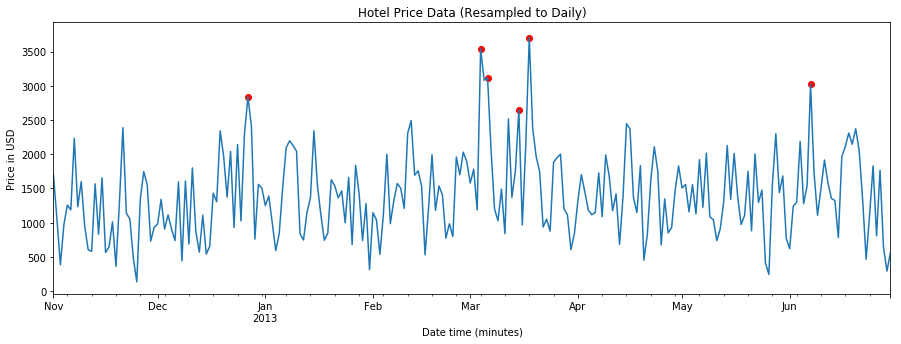

In [274]:
ts2_daily = ts2.resample('1D').sum()
anoms = tad(ts2_daily, max_anoms=0.1, direction='both', alpha=0.05, piecewise_median_period_weeks=2)['anoms']

fig, ax = plt.subplots(1, figsize=(15,5))  # , xlim=(None,'2012-11-04')
ts2_daily.plot(ax=ax)
ax.scatter(anoms.index.values, anoms, color='red')
ax.set_xlabel('Date time (minutes)')
ax.set_ylabel('Price in USD')
ax.set_title('Hotel Price Data (Resampled to Daily)');